# Dataset

The dataset used was created using the YouTube API V3, which allows efficient and fast downloading of comments. To use the YouTube API you must first create a google account and enable the YouTube API in the Google developer console.The API key required to send requests to the API is also provided on this developer console. A major limitation of the API is that it is has a quota allocation 10,000 units per day, which limits the use of the API. The API works in a paged fashion, returning a limited number of results. The response always contains a `nextPageToken` which can be used to obtain the next results. This means that multiple requests need to be made to get all the comments for a video. However, one can live with this limitation, since a read operation costs only one unit and delivers a hundred comments plus replies.

To get started, the api key and the playlist ID are inserted first. The "tagesschau" channel provides a playlist that lists the 8 p.m. videos in almost chronological order. The order is only almost chronological, because some videos have been deleted and re-uploaded. These videos often contain only fewer comments, as many have been lost when the video was deleted. However, deleted and re-uploaded videos only occur very rarely and therefore this limitation could be neglected. Then the YouTube API is initialized and ready for use.

In [3]:
from googleapiclient.discovery import build
import pandas as pd

api_key = '' # Insert your own API key
playlist_id = "PL4A2F331EE86DCC22"
max_results_comments = 100
max_results_playlist = 50

youtube_api = build('youtube', 'v3', developerKey=api_key)

To avoid problems with the quota limit, it was decided to download the comments of the 500 most recent videos. Assuming that the videos were uploaded in chronological order, we know that the videos cover the period from the 8th of September 2021 to the 21st of January 2023. Since a maximum of 50 videos are returned when playlist items are queried, 10 queries are sent to obtain the most recent 500 videos. Once all video IDs have been extracted, they are stored in a .csv file to make the results reproducible.

In [2]:
video_ids = []
playlist_response = youtube_api.playlistItems().list(part="snippet", playlistId=playlist_id, maxResults=max_results_playlist).execute()

for i in range(10):
    for item in playlist_response["items"]:
        video_ids.append(item["snippet"]["resourceId"]["videoId"])
        if "nextPageToken" in playlist_response:
            next_page_token = playlist_response["nextPageToken"]
        else:
            break
    playlist_response = youtube_api.playlistItems().list(part="snippet", playlistId=playlist_id, maxResults=max_results_playlist).execute()

len(video_ids)

500

In [3]:
df = pd.DataFrame(data=video_ids, columns=["video_ids"])
df.to_csv("data/youtube_video_ids_500.csv")

To download the comments three functions are implemented. The first function extracts the comments from a comment thread. The second function sends a request to the YouTube API to load a comment thread. The third function iterates over a list of video IDs and uses the first two functions to download all comment threads and to extract all comment. Once all comments have been extracted, they are stored in a .csv file, just like the video IDs before. It is important to note that for performance reasons and quota limitation, only the comment thread function of the YouTube API was used. This function has the limitation that for each comment, only part of the reply comments are included and not all. To get all the replies would require sending requests to another API endpoint. Since this would massively slow down the speed of collecting the comments, it was decided not to do this and thus not to download a part of the reply comments. Downloading all comments took about 20 minutes.

In [4]:
def load_comments(comment_thread):
    comment_list = []
    for item in comment_thread["items"]:
        comment = item["snippet"]["topLevelComment"]
        comment_text = comment["snippet"]["textDisplay"]
        comment_list.append(comment_text)
        if 'replies' in item.keys():
            for reply in item['replies']['comments']:
                reply_text = reply["snippet"]["textDisplay"]
                comment_list.append(reply_text)
    return comment_list


def get_comment_thread(video_id, page_token=None):
    comment_thread = youtube_api.commentThreads().list(part="snippet, replies", maxResults=max_results_comments, videoId=video_id, textFormat="plainText", pageToken=page_token).execute()
    return comment_thread


def scrape_comments(video_ids: list):
    progress_counter = 0
    comment_data = []
    for video_id in video_ids:
        comment_thread = get_comment_thread(video_id)
        if "nextPageToken" in comment_thread:
            next_page_token = comment_thread["nextPageToken"]
        else:
            next_page_token = None

        comment_data.extend(load_comments(comment_thread))

        while next_page_token:
            comment_thread = get_comment_thread(video_id, next_page_token)
            if "nextPageToken" not in comment_thread:
                break
            else:
                next_page_token = comment_thread["nextPageToken"]

            comment_data.extend(load_comments(comment_thread))

        if progress_counter%100 == 0:
            print(f"Progress: {progress_counter/len(video_ids)}")
        progress_counter+=1

    print("Finished")
    return comment_data

In [5]:
comment_data = scrape_comments(video_ids)

Progress: 0.0
Progress: 0.2
Progress: 0.4
Progress: 0.6
Progress: 0.8
Finished


In [34]:
df = pd.DataFrame(data=comment_data, columns=["Comments"])
df.to_csv("data/youtube_comments_500.csv")

## Data understanding

To see if everything worked out, we can take a look at the data collected. We can see that everything worked and that we collected 406,242 comments.

In [6]:
comments_df = pd.read_csv ("data/youtube_comments_500.csv")
comments_df = comments_df.drop(columns=comments_df.columns[0], axis=1) # Drop the index stored in the .csv file to improve readability.
display(comments_df)

,Comments
0,wollt ihr jetzt jeden tag einen großen bericht...
1,"Wenn Scholz alles besser weiss, wieso braucht ..."
2,Die Grünen hatten Früher das Peace Zeichen als...
3,Der Westen ist ein Kriegstreiber bis es zu ein...
4,Frieden schaffen ohne Waffen.
...,...
406237,"Kann jeder deutscher werden ,kein Problem sola..."
406238,Dann nimm die Leute bei dir auf und verpflege ...
406239,🙄🤔als Staatenloser hatt mans aber auch nicht l...
406240,Wann kommt der Blackout? Kinder könnt ihr ja e...


If we look at the length of the comments, we notice that most of them are less than 200 characters long. This is particularly important for the analysis with transformers, as these usually only support a limited text length.

Text(0, 0.5, 'Number of comments')

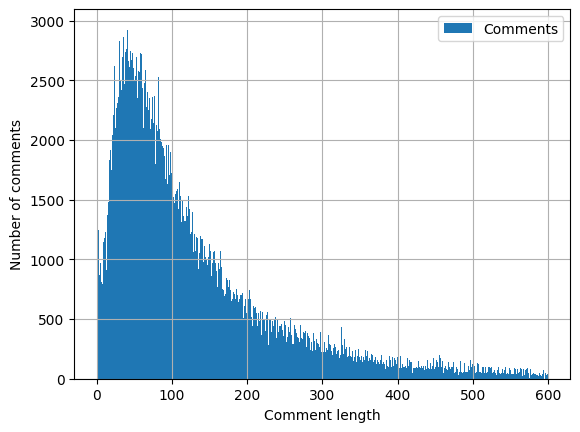

In [26]:
plot = comments_df.Comments.str.len().hist(legend=True, bins=600, range=[0,600])
plot.set_xlabel("Comment length")
plot.set_ylabel("Number of comments")